In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate'):
    for filename in filenames:
        os.path.join(dirname, filename) 

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MultiHeadAttention 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [3]:
import os
import pandas as pd

BASOPHIL_dirs = [r'/kaggle/input/no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Basophil']

EOSINOPHIL_dirs = [
    r'/kaggle/input/no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Eosinophil'
]

LYMPHOCYTE_dir = [ r'/kaggle/input/no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Lymphocyte']

MONOCYTE_dirs = [
    r'/kaggle/input/no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Monocyte'
]

NEUTROPHIL_dirs = [
    r'/kaggle/input/no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Neutrophil'
]

filepaths = []
labels = []
dict_lists = [BASOPHIL_dirs, EOSINOPHIL_dirs, LYMPHOCYTE_dir, MONOCYTE_dirs, NEUTROPHIL_dirs]
class_labels = ['BASOPHIL','EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                                           filepaths    labels
0  /kaggle/input/no-augmentation-randomrotate/wbc...  BASOPHIL
1  /kaggle/input/no-augmentation-randomrotate/wbc...  BASOPHIL
2  /kaggle/input/no-augmentation-randomrotate/wbc...  BASOPHIL
3  /kaggle/input/no-augmentation-randomrotate/wbc...  BASOPHIL
4  /kaggle/input/no-augmentation-randomrotate/wbc...  BASOPHIL
labels
NEUTROPHIL    6231
LYMPHOCYTE    2427
EOSINOPHIL    2132
MONOCYTE      1590
BASOPHIL       602
Name: count, dtype: int64


In [4]:
bloodCell_df.shape

(12982, 2)

In [5]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

After the data is placed into the model, we split the model into:
- 70% for training data 
- 30% for testing data. 

Then, we will use K-Fold Cross-Validation to evaluate the performance of this model. We set up that the model will split the data into 5 subsets and will shuffle before splitting. We also set a random seed as 42 to ensure the same shuffle pattern across multiple runs of code.

In [6]:
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train = image_gen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )


Found 9087 validated image filenames belonging to 5 classes.
Found 3895 validated image filenames belonging to 5 classes.


This part is using to create data generators for training and testing dataset with using ImageDataGenerator. These generators can help us to preprocess the image from the specified paths follow our requirement.
When the preprocessing on the image, the input images will be converted from RGB to BGR by preprocess_input, after that will zero-center each color channel in relation to the ImangeNet dataset without scaling.

After that, we generate the image from two data frame, which are train_set and test_images. There are some parameters when generating the image:
- Resize images into (244, 244) 
- Convert the images from BGR to RGB. 
- Outcome with a class mode of categorical, this will be more suitable for categorical classification tasks. 
- The number of images for each batch set as 8
- prevents shuffling of data.


In [7]:
classes=list(test.class_indices.keys())
print (classes)

['BASOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


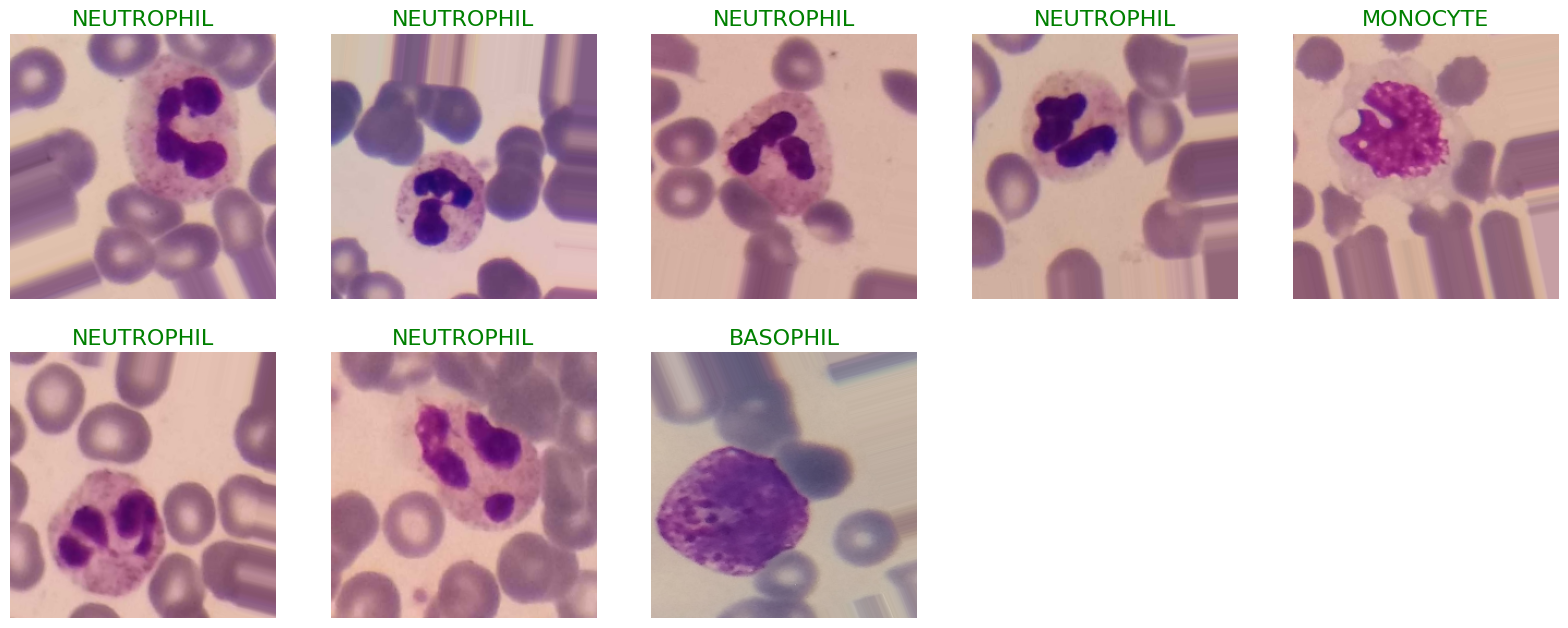

In [8]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(test)

This function is to display a batch of images from the test dataset. The images will display with a size of 20*20.

In [9]:
# Function to create the model
from tensorflow.keras import layers, Model
def create_model():
    inputs = keras.Input(shape=(244, 244, 3))

    # Initial convolutional layers
    x = layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(3, 3))(x)

    x = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Reshape for Multi-Head Attention
    x = layers.Reshape((256, -1))(x)

    # Multi-Head Attention layer
    attention_output = layers.MultiHeadAttention(num_heads=6, key_dim=64)(x, x)
    x = layers.LayerNormalization()(attention_output)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer for 5 classes
    outputs = layers.Dense(5, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
   
    return model


After that, we have created a function to create the model with convolution layers. We use the input layer with size of 244 * 244 and 3 channels. We start with initial convolutional layers. For the first convolutional layer, we do a convolution with applying 128 filters of size 8 * 8 with stride of 3, also an activation with ReLU. Then have a batch normalization to stabilize the output of convolution and speeds up the convergence. Same with the first, we will have a convolution but using 256 filters that having a size of 5 * 5 with strides 1. After that, a batch normalization and a max pooling that can reduce the spatial dimensions of feature maps with using 3 * 3 pooling operation. The last convolutional layer using 256 filters that having a size of 3 * 3 and follow by a batch normalization. 

After all the convolutional layers, we are having a reshape for Multi-head Attention. We reshape into 256 of sequence length and -1 computes the feature dimension. 

Then, come to the Multi-Head Attention layer. We are using 6 attention heads and each head with 64 key dimensions. This enables the model to focus on many feature map regions simultaneously. Next, having a layer normalization to stabilize the output.

Then, we done flatten and dense layer. Flatten is used to convert 3D tensor to 1D vector for dense layers. Dense is used for fully connected layers with 1024 neurons each and ReLU activation. We also used dropout to randomly drop 60% of the neurons during the training, this can regularize the model. The dense and dropout will do two times.
After done the flatten and dense layers, we have an output with 5 classes and produce probabilities for multi-class classification with using softmax activation function. Lastly, we have a model compilation between the input and output with using Adam as optimizer, categorical_crossentropy for loss function and evaluate the performance with accuracy. After done all of this will return the model.


In [10]:
model1 = create_model()
model1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
     )
print("Model input shape:", model1.input_shape)
print("Model output shape:", model1.output_shape)

Model input shape: (None, 244, 244, 3)
Model output shape: (None, 5)


We create a new model and compile it using SGD optimizer with 0.001 learning rate that can control the sizes of the steps taken during optimization.

In [11]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 79, 79,    │     24,704 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 79, 79,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 79, 79,    │    819,456 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 79, 79,    │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 26, 26,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 26, 26,    │    590,080 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256, 676)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 676)  │  1,040,164 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 676)  │      1,352 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 173056)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 177,210,3… │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  1,049,600 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │      5,125 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 180,743,409 (689.48 MB)

 Trainable params: 180,742,129 (689.48 MB)

 Non-trainable params: 1,280 (5.00 KB)

We summary up all the output after each layer.

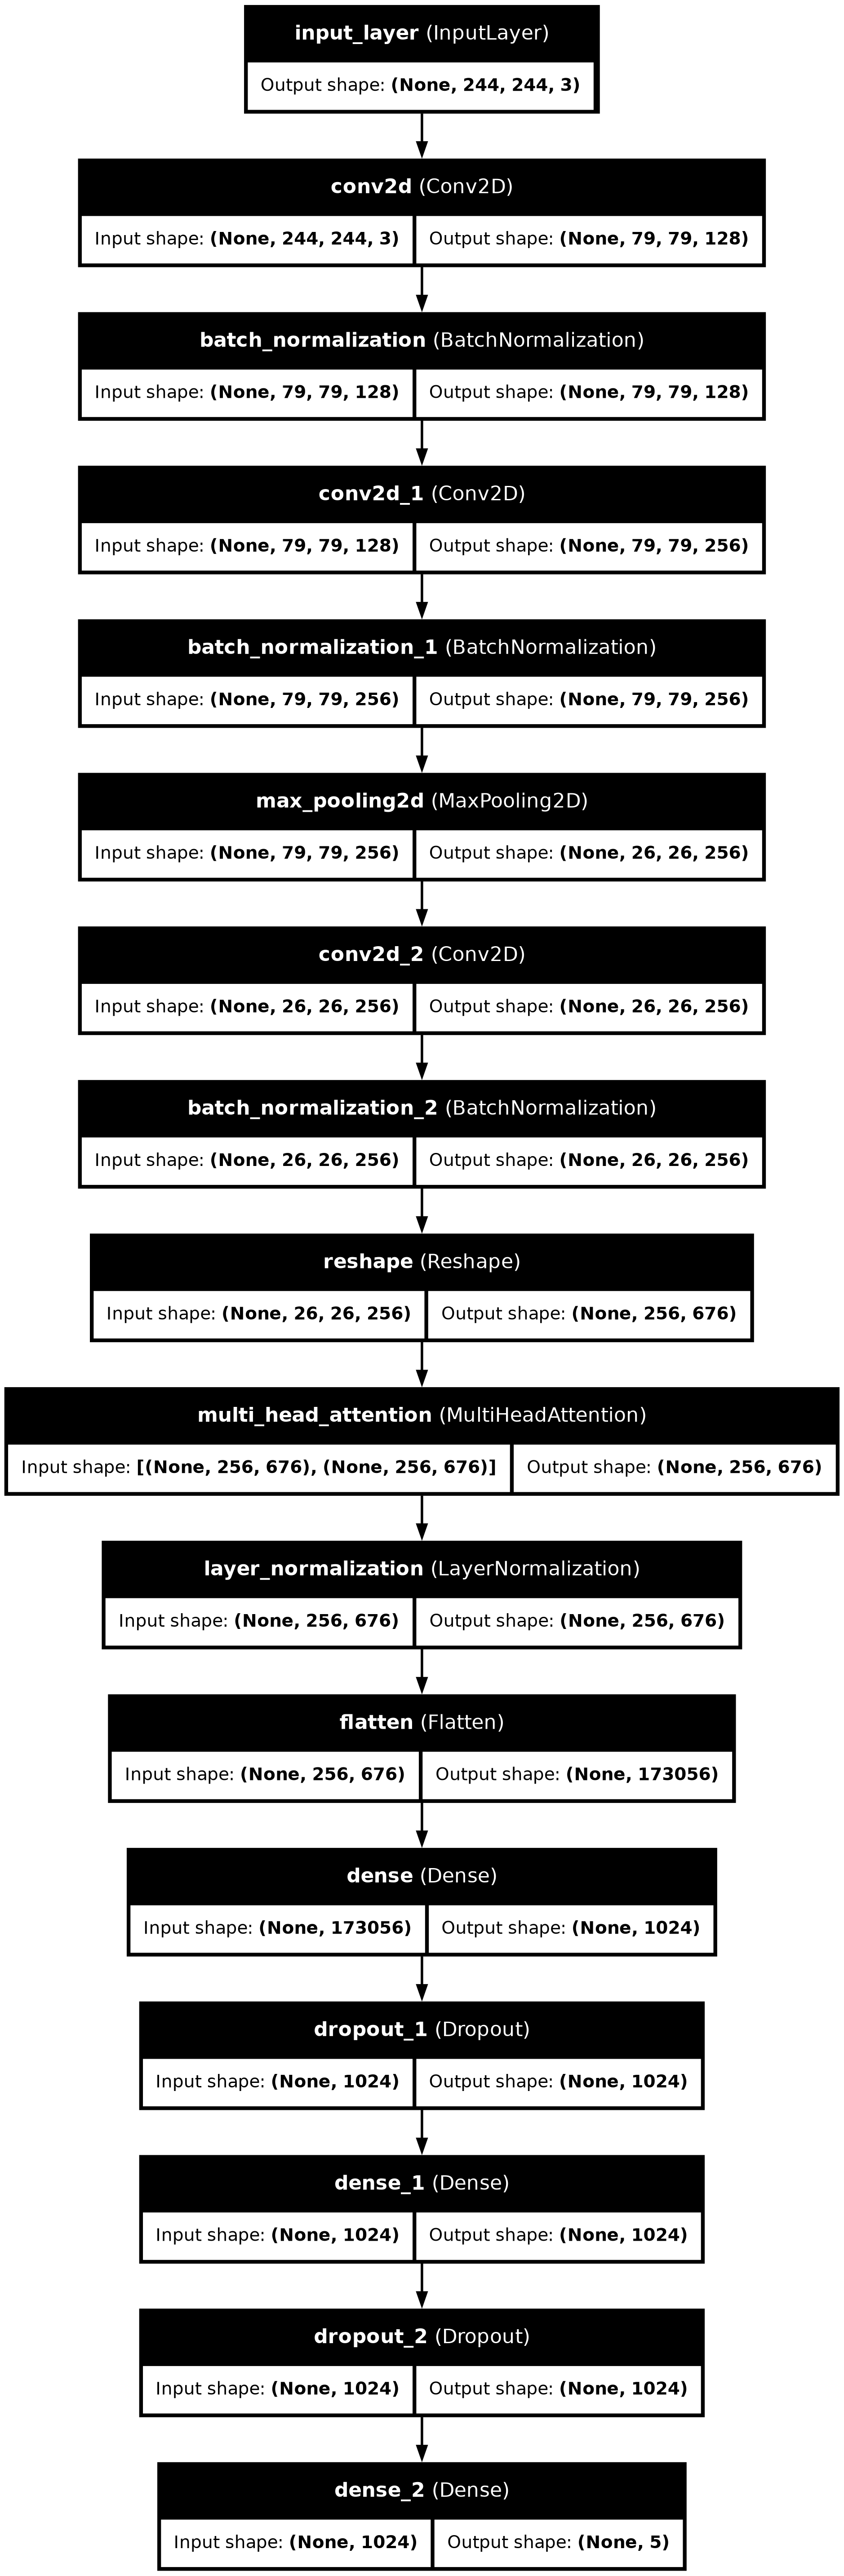

In [12]:
from keras.utils import plot_model

plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
fold = 1
accuracies = []

In [14]:
for train_index, val_index in kf.split(bloodCell_df):
    print(f"\nTraining on Fold {fold}...")
    
    # Split data for current fold
    train_df = bloodCell_df.iloc[train_index]
    val_df = bloodCell_df.iloc[val_index]
    
    # Create train and validation generators
    train_gen = image_gen.flow_from_dataframe(
        dataframe=train_df,
        x_col="filepaths",
        y_col="labels",
        target_size=(244, 244),
        color_mode='rgb',
        class_mode="categorical",
        batch_size=8,
        shuffle=True
    )
    
    val_gen = image_gen.flow_from_dataframe(
        dataframe=val_df,
        x_col="filepaths",
        y_col="labels",
        target_size=(244, 244),
        color_mode='rgb',
        class_mode="categorical",
        batch_size=8,
        shuffle=False
    )
    
    # Create a new model for each fold
    model = create_model()
    model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
     )
    # Train the model
    history = model.fit(train_gen, epochs=20, validation_data=val_gen, verbose=1)
    
    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold} - Validation Accuracy: {val_acc:.4f}")
    
    accuracies.append(val_acc)
    fold += 1


Training on Fold 1...
Found 10385 validated image filenames belonging to 5 classes.
Found 2597 validated image filenames belonging to 5 classes.
Epoch 1/20


I0000 00:00:1733984080.987642      68 service.cc:145] XLA service 0x78850000d3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733984080.987703      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   1/1299 ━━━━━━━━━━━━━━━━━━━━ 4:04:30 11s/step - accuracy: 0.1250 - loss: 1.8040

I0000 00:00:1733984089.637665      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 233s 171ms/step - accuracy: 0.5652 - loss: 1.0979 - val_accuracy: 0.7378 - val_loss: 0.6895
Epoch 2/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 178s 136ms/step - accuracy: 0.7611 - loss: 0.6902 - val_accuracy: 0.7166 - val_loss: 0.9375
Epoch 3/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 178s 137ms/step - accuracy: 0.8124 - loss: 0.5601 - val_accuracy: 0.6592 - val_loss: 1.0546
Epoch 4/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 177s 136ms/step - accuracy: 0.8443 - loss: 0.4824 - val_accuracy: 0.7901 - val_loss: 0.5984
Epoch 5/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 176s 135ms/step - accuracy: 0.8601 - loss: 0.4413 - val_accuracy: 0.7921 - val_loss: 0.7008
Epoch 6/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 177s 136ms/step - accuracy: 0.8767 - loss: 0.4033 - val_accuracy: 0.9207 - val_loss: 0.2325
Epoch 7/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 178s 137ms/step - accuracy: 0.8816 - loss: 0.3719 - val_accuracy: 0.9180 - val_loss: 0.2332
Epoch 8/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 179s 137ms/step - accuracy: 0.8

Now, we use a for loop to do the K-Fold Cross-Validation. We first spit the data for current fold and create a training generator with shuffle and validation generator without shuffle. Then, we create a new model for each fold. We compile this model using SGD optimizer with 0.001 learning rate that can control the sizes of the steps taken during optimization. We train the model on training generator with 20 epochs and use validation generator for validation during training as well as show out the training progress.

After the training, we evaluate the model on the validation set. We get the output of loss and accuracy and print it out for current fold. We store the accuracies for each fold in a list and increment the counter after each fold for tracking.

In [15]:
average_accuracy = np.mean(accuracies)
print(f"\nAverage Validation Accuracy: {average_accuracy:.4f}")


Average Validation Accuracy: 0.9509


In [16]:
history = model1.fit(train, epochs=20, validation_data=train, verbose=1)

Epoch 1/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 259s 223ms/step - accuracy: 0.5550 - loss: 1.1243 - val_accuracy: 0.7834 - val_loss: 0.6215
Epoch 2/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 243s 214ms/step - accuracy: 0.7567 - loss: 0.6845 - val_accuracy: 0.8072 - val_loss: 0.5066
Epoch 3/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 243s 214ms/step - accuracy: 0.8040 - loss: 0.5732 - val_accuracy: 0.8617 - val_loss: 0.3988
Epoch 4/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 243s 213ms/step - accuracy: 0.8381 - loss: 0.4817 - val_accuracy: 0.9030 - val_loss: 0.2979
Epoch 5/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 242s 213ms/step - accuracy: 0.8566 - loss: 0.4522 - val_accuracy: 0.8589 - val_loss: 0.4322
Epoch 6/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 244s 214ms/step - accuracy: 0.8679 - loss: 0.4102 - val_accuracy: 0.9224 - val_loss: 0.2402
Epoch 7/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 242s 213ms/step - accuracy: 0.8871 - loss: 0.3567 - val_accuracy: 0.9174 - val_loss: 0.2487
Epoch 8/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 242s 212ms/step - ac

We train a model with 20 epochs on the training dataset and use the same dataset to validation during the training. 

In [17]:
model1.evaluate(test, verbose=1)

487/487 ━━━━━━━━━━━━━━━━━━━━ 57s 118ms/step - accuracy: 0.9571 - loss: 0.1571


[0.1639455109834671, 0.9525032043457031]

We evaluate the model after training with test dataset.

In [18]:
history1 = model1.fit(train, epochs=1, validation_data=train, verbose=1)

1136/1136 ━━━━━━━━━━━━━━━━━━━━ 243s 214ms/step - accuracy: 0.9277 - loss: 0.2190 - val_accuracy: 0.9219 - val_loss: 0.2321


We do one more training but with only 1 epoch, this is for tuning purposes. 

In [19]:
model1.evaluate(test, verbose=1)

487/487 ━━━━━━━━━━━━━━━━━━━━ 51s 105ms/step - accuracy: 0.9208 - loss: 0.2313


[0.2386341243982315, 0.9222079515457153]

We evaluate the model after training with test dataset.

In [20]:
model1.save("Blood Cell.h5")

In [21]:
pred = model1.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

487/487 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step


We do a prediction with using the test dataset and pick the class with highest probability. Then we convert the class indices into the class name we can read.

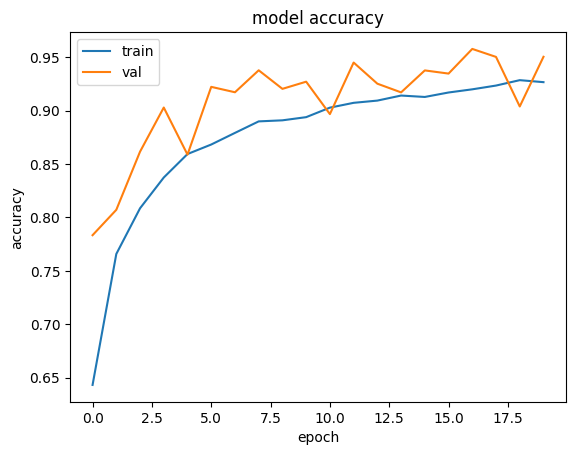

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

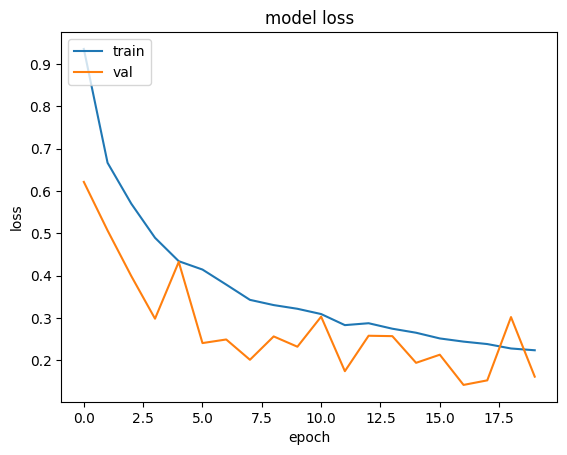

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

    BASOPHIL       0.88      1.00      0.94       186
  EOSINOPHIL       0.98      0.76      0.86       633
  LYMPHOCYTE       0.86      0.93      0.90       746
    MONOCYTE       0.75      0.94      0.84       488
  NEUTROPHIL       0.99      0.96      0.97      1842

    accuracy                           0.92      3895
   macro avg       0.89      0.92      0.90      3895
weighted avg       0.93      0.92      0.92      3895

Accuracy of the Model: 92.0%


We generate a detailed report that includes precision, recall, F1-score and support, to compare the true labels (y_test) and predicted class name (pred2).

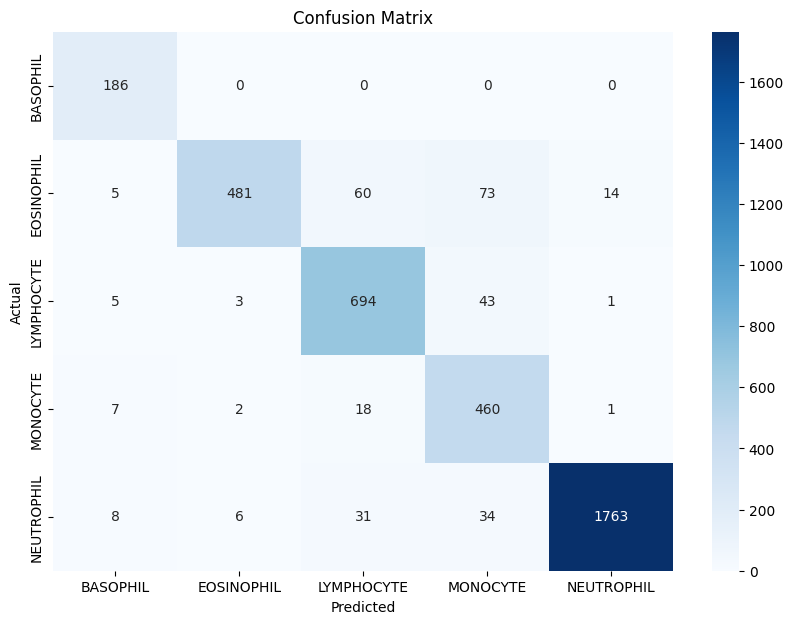

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['BASOPHIL','EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

This code is using to show the confusion matrix of our results.